## 0.Librerías

In [1]:
import os
import pandas as pd
import time

import numpy as np
from tqdm import tqdm
#from skimage.io import imread, imshow
#from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime
import cv2
#Metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
%env SM_FRAMEWORK=tf.keras
# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import segmentation_models as sm
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


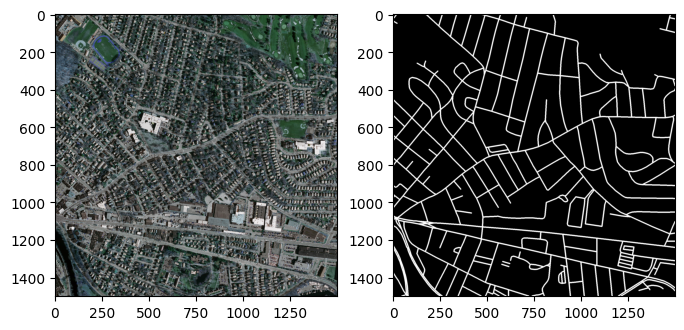

In [2]:
# Mostramos la imagen y su mascara asociada
m=18
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
img=cv2.imread('../roads_png/train/22679020_15.png')[:,:,:3]
plt.imshow(img)
plt.subplot(1,2,2)
img=cv2.imread('../roads_png/train_labels/22679020_15.png')[:,:,:3]
plt.imshow(img, cmap='gray')
plt.show()

# 1.Preprocesado Con cortes

Como las imagenes son muy grandes (1500x1500) hay dos opciones, podemos reducir su tamaño perdiendo resolucion y calidad de imagen pero manteniendo la info espacial o realizar cortes de tamaño deseado manteniendo así la resolucion en pro de perder esa info espacial por corte. Debido al tamaño pequeño de las construcciones, creo que es más importante tener más resolución.

In [2]:
def obtener_corte(img,cut=224,tipo='img'):
    """
    FUNCION:    Obtener cortes de una imagen dada de un tamaño (cutxcut)

    PARAMS:
        img: np.array de la imagen por cv2.imread()
        cut: tamaño del corte
        type: indica si es una imagen o su mascara (msk)

    RETURN:
        array_tot: np.array(numero_cortes,cut,cut,canales) donde canales son 3 en las imagenes
        normales y nada en las mascaras

    """
    # Obtener las dimensiones de la imagen (alto, ancho, canales)
    if tipo == 'img':
        alto, ancho, _ = img.shape
        formato=(1,cut,cut,3)
    elif tipo == 'msk':
        alto, ancho= img.shape
        formato=(1,cut,cut)

    # Definir las coordenadas para el recorte
    max_val_recorte=alto-cut
    max_val_recorte_x=ancho-cut
    array_tot=np.array([])
    #bucle ene le eje X
    for j in range(1,int(ancho/cut)+2):
        if cut*j<ancho:
            corte_ini_x=cut*(j-1)
            corte_fin_x=cut*j
        else:
            corte_ini_x=max_val_recorte_x
            corte_fin_x=ancho
        #Bucle en el eje Y
        for i in range(1,int(alto/cut)+2):
            if cut*i<alto:
                corte_ini=cut*(i-1)
                corte_fin=cut*i
            else:
                corte_ini=max_val_recorte
                corte_fin=alto
            # Realizar el recorte de la imagen
            if tipo == 'img':
                trozo_imagen = img[corte_ini:corte_fin, corte_ini_x:corte_fin_x,:]
            elif tipo == 'msk':
                trozo_imagen = img[corte_ini:corte_fin, corte_ini_x:corte_fin_x]
            #agrupar imagenes en un mismo array
            if array_tot.shape[0]>0:
                array_tot=np.vstack([array_tot,trozo_imagen.reshape(formato)])
            else:
                array_tot=trozo_imagen.reshape(formato)
    return array_tot
def num_percentage(img,num=0):
    """
    FUNCION: Devuelve el factor existente entre pixeles de un numero concreto y los pixeles totales de la imagen

    PARAMS:
        img: np.array de la imagen por cv2.imread()

    RETURN:
        num_factor= float pixeles del numero num/ pixeles totales

    """
    total_pixels = img.shape[0] * img.shape[1]
    num_pixels = np.sum(img == num)  # Contar píxeles blancos
    num_factor=num_pixels / total_pixels
    return num_factor
def filter_cut_images(data_path_images, data_path_masks,cut=224,positive_min_mask=0.001,limite=0):
    """
    FUNCION: Dados los directorios donde se encuentran imagenes y mascaras, obtener los recortes de cada una de ellas

    PARAMS:
        data_path_images,data_path_masks: path de imagenes y mascaras
        cut: tamaño del corte
        positive_min_mask: indica el factor minimo de puntos blancos/valores positivos en una mascara. Esto es ideal
            para filtrar imagenes con mucho fondo (valores negativos) vs información (mascara/valores positvos)
        limite: limita el numero de imagenes que se van a procesar. Ideal por si tenemos demasiadas
    RETURN:
        white_factor= float pixeles blancos/ pixeles totales
        final_images: np.array(num,cut,cut,3) array con los resultados de los cortes para las imagenes
        final_masks: np.array(num,cut,cut) array con los resultados de los cortes para las mascaras
    """

    data_list_images = os.listdir(data_path_images)
    final_images = []
    final_masks = []
    num_img_discard=0
    mask_factors=[]

    limite = len(data_list_images) if limite == 0 else limite

    for file_name in tqdm(data_list_images[:limite]):
        # Leer la imagen
        img = cv2.imread(os.path.join(data_path_images, file_name))[:,:,:3]
        mask_file = os.path.splitext(file_name)[0] + '.png'  # Nombre de la máscara
        mask_path = os.path.join(data_path_masks, mask_file)
        if os.path.exists(mask_path):
            # Leer mascara
            mask = cv2.imread(mask_path)[:,:,1]
            mask_factor=num_percentage(mask,255)
            if mask_factor>positive_min_mask:
                mask_factors.append(mask_factor)
                # Obtener cortes
                img_trozos_imagen=obtener_corte(img,cut,tipo='img')
                #agregar a lista
                img_trozos_list=[trozo for trozo in img_trozos_imagen]
                final_images+=img_trozos_list
                #obtener cortes de la mascara
                mask_trozos_imagen=obtener_corte(mask,cut,tipo='msk')
                #agregar a lista
                mask_trozos_list=[trozo for trozo in mask_trozos_imagen]
                final_masks+=mask_trozos_list
            else:
                num_img_discard+=1
        else:
            num_img_discard+=1
    print(f'Se han descartado {num_img_discard} imagenes')
    # Convertir las listas en arrays NumPy
    final_images = np.asarray(final_images, dtype=np.uint8)
    final_masks = np.asarray(final_masks, dtype=np.uint8)
    #Pasamos valores de 255 a 1
    final_masks[final_masks==255]=1
    mask_factors =np.array(mask_factors)

    return final_images, final_masks, mask_factors


**Nota**: hay que limitar el numero de imagenes, en el entrenamiento se obtienen 36000 cortes, a la hora de hacer el enetrenamiento desde Google Collab se superan por bastante los límites de GPU y CPU

In [ ]:
# Definir las dimensiones de las imágenes
cut=224
positive_min_mask=0.005
dire=''
# Directorios de los conjuntos de datos
data_path_train = dire+"roads_png/train"
data_path_train_mask = dire+"roads_png/train_labels"
data_path_test = dire+"roads_png/test"
data_path_test_mask = dire+"roads_png/test_labels"
data_path_val = dire+"roads_png/val"
data_path_val_mask = dire+"roads_png/val_labels"

X_train_pro, Y_train_pro, mask_factors_train = filter_cut_images(data_path_train, data_path_train_mask, cut=cut,positive_min_mask=positive_min_mask,limite=200)
print('X_train:', X_train_pro.shape)
print('Y_train:', Y_train_pro.shape)

X_test_pro, Y_test_pro, mask_factors_test = filter_cut_images(data_path_test, data_path_test_mask, cut=cut,positive_min_mask=positive_min_mask,limite=10)
print('X_test:', X_test_pro.shape)
print('Y_test:', Y_test_pro.shape)

X_val_pro, Y_val_pro, mask_factors_val = filter_cut_images(data_path_val, data_path_val_mask, cut=cut,positive_min_mask=positive_min_mask,limite=5)
print('X_val:', X_val_pro.shape)
print('Y_val:', Y_val_pro.shape)

100%|██████████| 104/104 [01:54<00:00,  1.10s/it]


Se han descartado 1 imagenes
X_train: (5047, 224, 224, 3)
Y_train: (5047, 224, 224)


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


Se han descartado 0 imagenes
X_test: (490, 224, 224, 3)
Y_test: (490, 224, 224)


100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

Se han descartado 0 imagenes
X_val: (245, 224, 224, 3)
Y_val: (245, 224, 224)


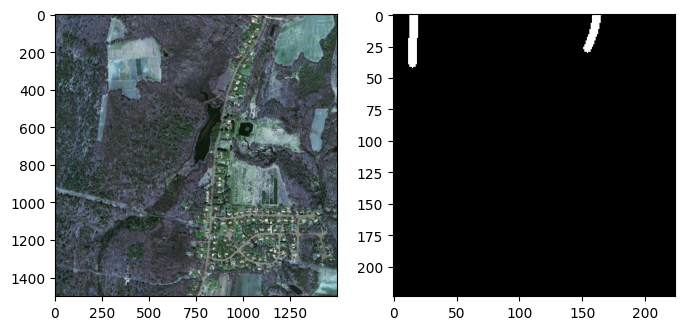

0.009925063775510204

In [ ]:
# Mostramos la imagen y su mascara asociada
m=48
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
img=cv2.imread('../roads_png/train/10078675_15.png')[:,:,:3]
plt.imshow(img)
plt.subplot(1,2,2)
img=cv2.imread('../roads_png/train_labels/10078675_15.png')[:,:,1]
img_corte=obtener_corte(img,cut=224,tipo='msk')
plt.imshow(img_corte[m], cmap='gray')
plt.show()
white_percentage(img_corte[m])

**Nota**: el dataset esta desbalanceado, es decir, el numero de valores positivos (estructuras) detectados en la mascara vs numero de valores negativos no es 50/50. Esto es importante a la hora de evaluar la calidad de los resultados

In [6]:

df_dat=pd.DataFrame({
    'Train':[mask_factors_train.max(),mask_factors_train.mean(),mask_factors_train.min()],
    'Test':[mask_factors_test.max(),mask_factors_test.mean(),mask_factors_test.min()],
    'Val':[mask_factors_val.max(),mask_factors_val.mean(),mask_factors_val.min()],
},index=['Max','Mean','Min'])
print('Factores asociados a Valores positivos/ Total valores')
display(df_dat)
time.sleep(0.1)
print('Precisiones esperadas en función de los valores positivos')
display(1-df_dat)

Factores asociados a Valores positivos/ Total valores


,Train,Test,Val
Max,0.102076,0.074118,0.118369
Mean,0.053050,0.034094,0.069223
Min,0.003050,0.005467,0.025168


Precisiones esperadas en función de los valores positivos


,Train,Test,Val
Max,0.897924,0.925882,0.881631
Mean,0.946950,0.965906,0.930777
Min,0.996950,0.994533,0.974832


Por ejemplo, en el entrenamiento, esperamos precisiones mínimas de 0.80 y en donde evolucionen a precisiones superiores al 0.94. Esto ya que al tener un 0.06 (1-0.06=0.94) de media de pixeles blancos un modelo que pusiese todos los valores a 0, obtendría esta precision de 0.94

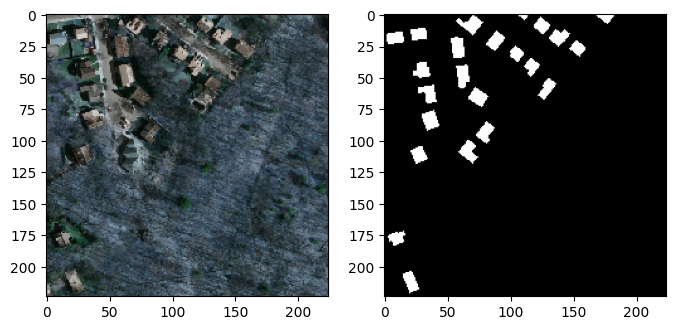

In [ ]:
# Mostramos la imagen y su mascara asociada
m=18
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(X_val_pro[m])
plt.subplot(1,2,2)
plt.imshow(Y_val_pro[m], cmap='gray')
plt.show()

# 2.Entrenamiento

In [7]:
# binary segmentation (this parameters are default when you call Unet('resnet34')
model_pro = sm.Unet('resnet50',input_shape=(224, 224, 3), classes=1, activation='sigmoid', encoder_weights='imagenet')
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_pro = preprocess_input(X_train_pro)
X_test_pro = preprocess_input(X_test_pro)

model_pro.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=['accuracy'],
)

94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [9]:
checkpoint = ModelCheckpoint(filepath='road_models/modelo-{epoch:02d}-{val_accuracy:.2f}.weights.h5',
                             monitor='val_accuracy',  # Puede ser 'val_accuracy' si prefieres
                             save_best_only=True,
                             save_weights_only=True,  # Para guardar toda la arquitectura y los pesos
                             mode='max',  # O 'max' si monitorizas 'accuracy'
                             verbose=1)

**Nota:** Debido al alto coste computacional este comando se ha ejecutado desde la GPU de Google Collab, como se ve, ha tardado unos 48min para solo 20 epocas.

In [10]:
start=time.time()
history=model_pro.fit(
   x=X_train_pro,
   y=Y_train_pro.astype(np.float16),
   batch_size=16,
   epochs=20,
   validation_data=(X_test_pro, Y_test_pro.astype(np.float16)),
   callbacks=[checkpoint],
)
print(f'Finalizado en {round(time.time()-start,2)} s')

Epoch 1/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9206 - loss: 0.9279
Epoch 1: val_accuracy improved from -inf to 0.97579, saving model to road_models/modelo-01-0.98.weights.h5
316/316 ━━━━━━━━━━━━━━━━━━━━ 248s 491ms/step - accuracy: 0.9208 - loss: 0.9271 - val_accuracy: 0.9758 - val_loss: 0.8136
Epoch 2/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9734 - loss: 0.5222
Epoch 2: val_accuracy improved from 0.97579 to 0.97784, saving model to road_models/modelo-02-0.98.weights.h5
316/316 ━━━━━━━━━━━━━━━━━━━━ 140s 287ms/step - accuracy: 0.9734 - loss: 0.5222 - val_accuracy: 0.9778 - val_loss: 0.7320
Epoch 3/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9758 - loss: 0.4913
Epoch 3: val_accuracy improved from 0.97784 to 0.98035, saving model to road_models/modelo-03-0.98.weights.h5
316/316 ━━━━━━━━━━━━━━━━━━━━ 141s 283ms/step - accuracy: 0.9758 - loss: 0.4913 - val_accuracy: 0.9804 - val_loss: 0.6158
Epoch 4/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 266

In [11]:
model_pro.save_weights('road_models/model_final.weights.h5')

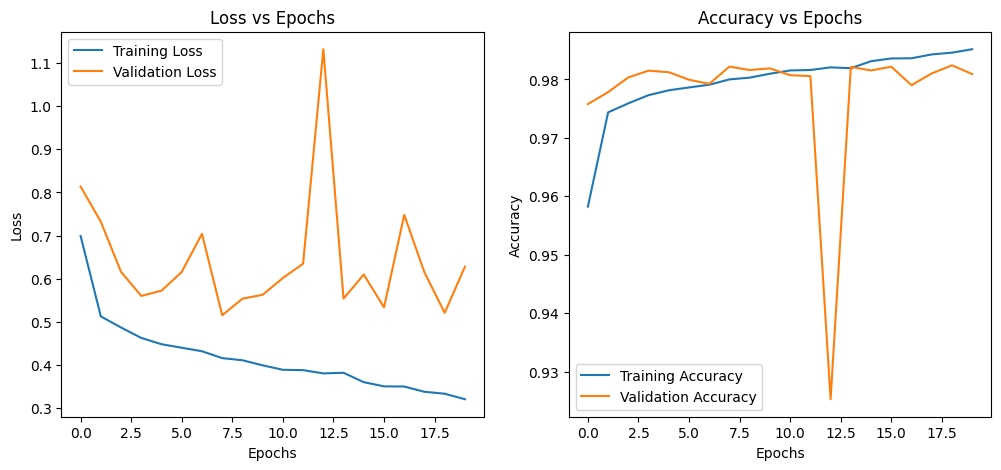

In [12]:
# Obtener los datos de 'loss' y 'accuracy' del objeto history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy')  # 'accuracy' es la métrica de precisión
val_accuracy = history.history.get('val_accuracy')  # Precisión en validación

# Crear el gráfico de Loss vs Epochs
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar los gráficos
plt.show()

**Nota:** Se ve como a partir de las 2-5 epocas la función pérdida en validación se estabiliza, además de fluctuar mucho. Lo mismo ocurre en precisones, siendo mas estable salvo en el pico de la epoca 11.

In [5]:
# Definir el backbone y la arquitectura del modelo sin encoder_weights
BACKBONE = 'resnet50'
model_load = sm.Unet(BACKBONE, classes=1, activation='sigmoid')
model_load.load_weights('../road_models/modelo-04-0.98.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


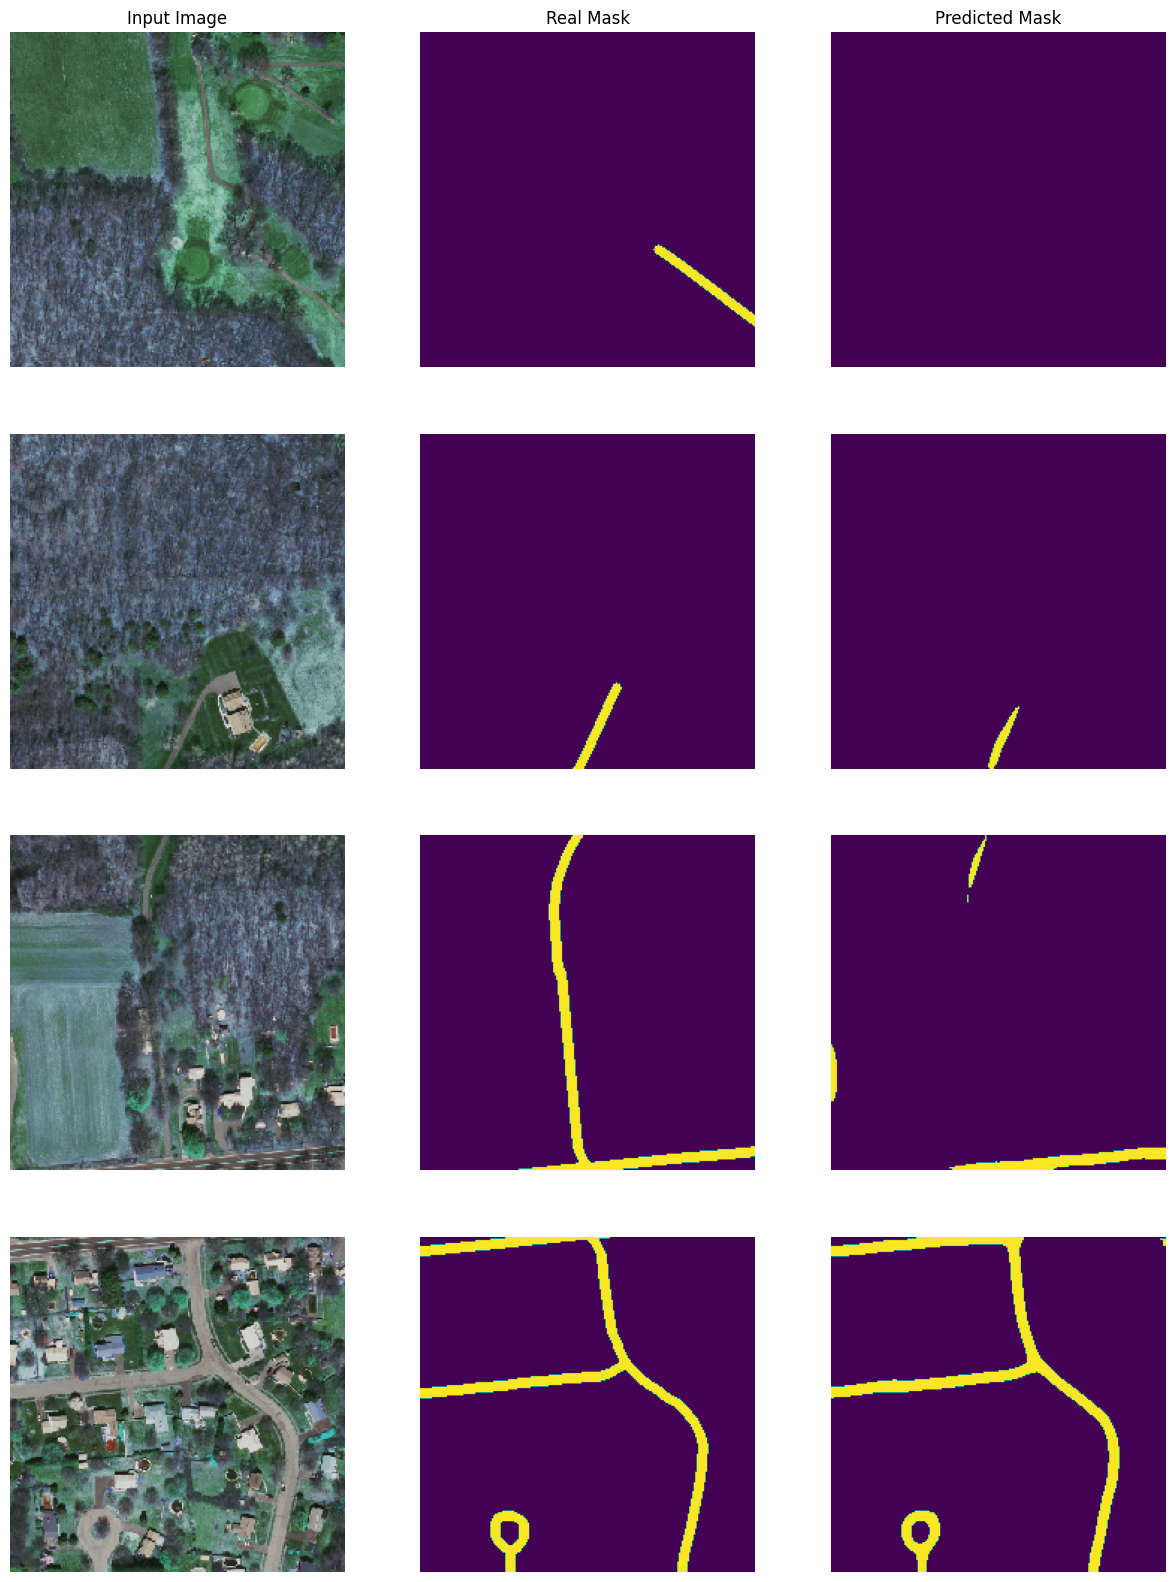

In [11]:
def plot_images_comparation(list_images_rows,titles_rows=["Input Image", "Real Mask", "Predicted Mask"]):
    num_rows = len(list_images_rows)
    fig=plt.figure(figsize=(15, 5*num_rows))
    index=1
    for i in range(num_rows):
        for j in range(3):
            plt.subplot(num_rows,3,index)
            plt.imshow(list_images_rows[i][j])
            plt.axis('off')
            if i==0:
                plt.title(titles_rows[j])
            index+=1
    plt.show()

# Índices de las imágenes que deseas mostrar agrupadas
max_image=4
# Preparar imágenes y títulos para visualizar en grupos de tres
images_list = []
preds=model_load.predict(X_val_pro[:4])
pred_binary = (preds > 0.5).astype(np.uint8)
# Agrupar imágenes y títulos en filas de tres
for i in range(0, 4):
    input_image = X_val_pro[i]
    ground_truth_mask = Y_val_pro[i]
    predicted_mask = pred_binary[i]
    images_list.append([input_image, ground_truth_mask, predicted_mask])
plot_images_comparation(images_list)


Aprovechando que el recorte de las imagenes se hace siempre de la misma forma, se puede construir una funcion que recurpere la imagen original

# Test
---

In [4]:
from sklearn.metrics import accuracy_score,f1_score
# Definir el backbone y la arquitectura del modelo sin encoder_weights
BACKBONE = 'resnet50'
model_load = sm.Unet(BACKBONE, classes=1, activation='sigmoid')
model_load.load_weights('../Trained_Models/road_models/modelo-08-0.98.weights.h5')

preds=model_load.predict(X_test_pro)
pred_binary = (preds > 0.5).astype(np.uint8)
y_test_flat = Y_test_pro.flatten()
pred_flat = pred_binary.flatten()
# accuracy
accuracy = accuracy_score(y_test_flat, pred_flat)
print('-'*60)
print('F1: ',round(f1_score(y_test_flat, pred_flat,average='macro'),4),'\nAccuracy: ',round(accuracy,4))

16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
------------------------------------------------------------
F1:  0.853 
Accuracy:  0.9822


# Prueba con una imagen cualquiera (Validación)

In [ ]:
def reconstruir_imagen(img_cuts,original_shape,typo='img'):
    """
    FUNCION: A partir de los cortes de una imagen, reconstruir la imagen original

    PARAMS: 
        img_cuts: np.array(num,cut,cut,) array con los cortes de la imagen
        original_shape: int tamaño de la imagen original
        typo: str tipo de imagen, imagen o mascara
    RETURN:
        reconstructed_img: np.array(original_shape,original_shape,) array de la img final reconstruida
    
    """
    num_cortes=img_cuts.shape[0]
    recorte=img_cuts.shape[1]
    num_cortes_eje=int(np.sqrt(num_cortes))
    #crear array base
    reconstructed_img=np.array([])
    if typo == 'img':
        reconstructed_img=np.zeros((original_shape,original_shape,3))
    elif typo=='msk':
        if len(img_cuts.shape)==3:
            reconstructed_img=np.zeros((original_shape,original_shape))
        elif len(img_cuts.shape)==4:
            reconstructed_img=np.zeros((original_shape,original_shape,1))
    index_tot=0
    #bucle en el eje x
    for i in range(num_cortes_eje):
        if i!=num_cortes_eje-1:
            corte_ini_x=(i)*recorte
            corte_fin_x=(i+1)*recorte
        else:
            corte_ini_x=original_shape-recorte
            corte_fin_x=original_shape
        #bucle en el eje y
        for j in range(num_cortes_eje):
            if j!=num_cortes_eje-1:
                corte_ini_y=(j)*recorte
                corte_fin_y=(j+1)*recorte
            else:
                corte_ini_y=original_shape-recorte
                corte_fin_y=original_shape
            #añadir recorte al array final
            if typo == 'img':
                reconstructed_img[corte_ini_y:corte_fin_y,corte_ini_x:corte_fin_x,:]=img_cuts[index_tot]
            elif typo=='msk':
                if len(img_cuts.shape)==3:
                    reconstructed_img[corte_ini_y:corte_fin_y,corte_ini_x:corte_fin_x]=img_cuts[index_tot]
                if len(img_cuts.shape)==4:
                    reconstructed_img[corte_ini_y:corte_fin_y,corte_ini_x:corte_fin_x,:]=img_cuts[index_tot]
            index_tot+=1
    return reconstructed_img

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 586ms/step


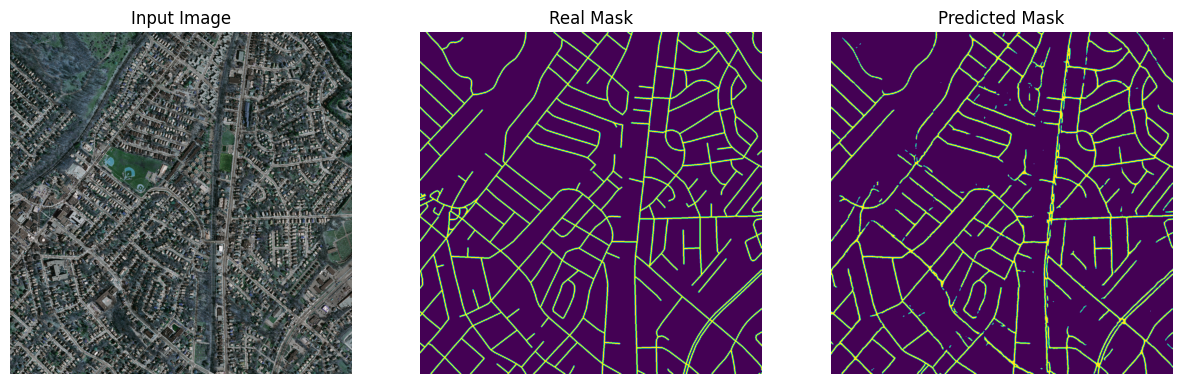

In [13]:
img=cv2.imread(r'..\roads_png\val\23128930_15.png')[:,:,:3]
img_mask=cv2.imread(r'..\roads_png\val_labels\23128930_15.png')[:,:,1]
#realizar corte
trozos_imagen=obtener_corte(img)
#predicciones
preds=model_load.predict(trozos_imagen)
pred_binary = (preds > 0.5).astype(np.uint8)
#reconstruyo la prediccion
pred_mask_recon=reconstruir_imagen(pred_binary,1500,tipo='msk')
# Mostrar las imágenes en filas de tres
plot_images_comparation([[img,img_mask,pred_mask_recon]])
#fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#for j in range(3):
#    axs[j].imshow([img,img_mask,pred_mask_recon][j])
#    axs[j].axis('off')
#    axs[j].set_title(["Input Image", "Ground Truth Mask", "Predicted Mask"][j])
#
#plt.show()


**Nota**: Es muy notable la diferencia entre predecir en ciudades (carreteras bien distinguidas) de zonas de campo, donde carreteras y caminos se camuflan mejor en el entorno. Debido a esto seguramente es por lo que la precisión en validación no aumenta.

In [14]:
#pred_binary = (preds > 0.5).astype(np.uint8)  # Si pred son probabilidades entre 0 y 1

# Asegúrate de que y_test también esté en el mismo formato
y_test_binary = (img_mask/255).astype(np.uint8)  # Convertir y_test si es necesario

# Aplanar ambos arrays para calcular la accuracy pixel a pixel
y_test_flat = y_test_binary.flatten()
pred_flat = pred_mask_recon.flatten()

# Calcular la accuracy
accuracy = accuracy_score(y_test_flat, pred_flat)
print(accuracy)

matriz_confusion = confusion_matrix(y_test_flat, pred_flat)

print("Matriz de Confusión:")
print(matriz_confusion)
report = classification_report(y_test_flat, pred_flat)
print(report)

0.9490648888888888
Matriz de Confusión:
[[1963009   55767]
 [  58837  172387]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97   2018776
           1       0.76      0.75      0.75    231224

    accuracy                           0.95   2250000
   macro avg       0.86      0.86      0.86   2250000
weighted avg       0.95      0.95      0.95   2250000



Se ve como precision, recall y f1 de la clase importante que es 1 que es quin nos indica si detecta estructura o no es aceptable, con indices de 0.76,0.75,0.75.

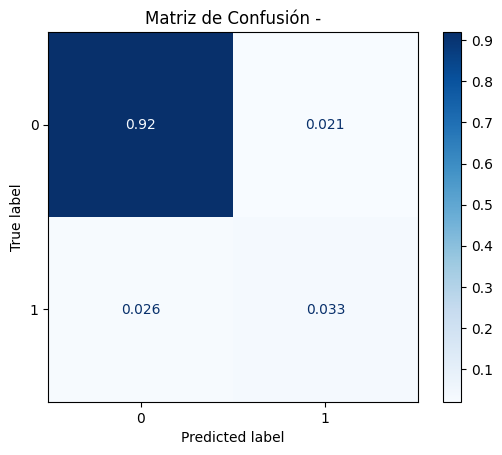

In [ ]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

class_names=list(range(matriz_confusion.shape[0]))
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion/pred_flat.shape[0], display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
# Añadir título y etiquetas
plt.title("Matriz de Confusión -")
plt.show()

# --------------------